In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import random
import gzip
import itertools

In [2]:
def pairwise(iterable):
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)  

In [3]:
def extract_data(filename, num_images, IMAGE_WIDTH):
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_WIDTH * IMAGE_WIDTH * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH*IMAGE_WIDTH)
        return data
    
    
def extract_labels(filename, num_images):
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [4]:
m = 2000
X = extract_data('t10k-images-idx3-ubyte.gz', m, 28)
Y = extract_labels('t10k-labels-idx1-ubyte.gz', m).reshape(m,1)

Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz


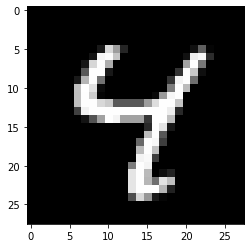

In [5]:
import matplotlib.cm as cm
plt.imshow(X[6].reshape((28, 28)), cmap=cm.Greys_r)
plt.show()

In [6]:
# нормализация данных
X -= int(np.mean(X))
X /= int(np.std(X))
X = X.reshape(len(X), 28, 28)    
    

X_train = []
for i in range(len(X)):
    x_even = X[i]
    x_rand_1 = random.choice(X)
    x_rand_2 = random.choice(X)
    x_zeros = np.zeros((28, 28)).reshape((28, 28))
    
    prom = np.vstack((x_zeros, x_even))
    prom = np.vstack((prom, x_zeros))
    prom = prom.reshape((84, 28))
    
    rand_1 = np.vstack((x_zeros, x_rand_1))
    rand_1 = np.vstack((rand_1, x_zeros))
    rand_1 = rand_1.reshape((84, 28))
    
    rand_2 = np.vstack((x_zeros, x_rand_2))
    rand_2 = np.vstack((rand_2, x_zeros))
    rand_2 = rand_2.reshape((84, 28))
    
    x_train = np.column_stack((rand_1, prom))
    x_train = np.column_stack((rand_2, x_train))
    X_train.append(x_train)
    
# X_train = np.asarray(X_train)
    
# num_pixels = X_train.shape[1] * X_train.shape[2]
# X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')

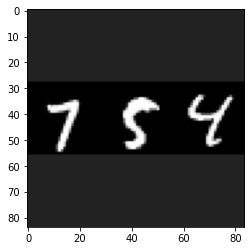

In [7]:
plt.imshow(X_train[6], cmap=cm.Greys_r)
plt.show()

In [8]:
for i in Y:
    if i[0] % 2 == [0]:
        i[0] = 0  # число четное
    else:
        i[0] = 1  # число нечетное
        
print(Y)

[[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


In [9]:
class Utils:
    @staticmethod
    def sigmoid(X):
        return 1 / (1 + np.exp(-X))

            
    @staticmethod
    def deriv_sigmoid(X):
        fx = Utils.sigmoid(X)
        return fx * (1 - fx)
    
    
    @staticmethod
    def mse_loss(Y, theta):
        return ((Y - theta) ** 2).mean()

    
    @staticmethod
    def softmax(X):
        out = np.exp(X)
        return out/np.sum(out)

    
    @staticmethod
    def cross_entropy_loss(Y, theta):
        return -np.sum(Y * np.log(theta))
    
    @staticmethod
    def gradient(theta, X, y):
        m = X.shape[0]
        gradient = (1 / m) * np.dot(X.T, (sigmoid(np.dot(X, theta)) - y))
        return gradient 


In [11]:
class Network():
    def __init__(self):
        self.iterations = 10  # количество итераций для градиентного спуска
        self.alpha = 0.1  # скорость обучения
        self.lamda = 0.5  # параметр для регуляризации
        self.n = 6  # слоев в нейросети
        self.m = [84, 42, 20, 10, 5, 1]  # массив числа нейронов для каждого слоя
    
    
    def backpropagation(self, deriv_grad_func, y, x, weights, theta, R):
        d_ypred = -2 * (y - theta[-1][0])
        sum_h = 0
        sum_old_h = 0
        old_w = list()
        for i in range(len(theta) - 1, 0, -1):
            if i == len(theta) - 1:
                old_w = weights[i]
                for k in range(len(theta[i])):
                    for z in range(len(weights[i][k])):
                        sum_h += weights[i][k][z] * theta[i - 1][z]
                    sum_h += R[i][k]
                    for z in range(len(weights[i][k])):
                        weights[i][k][z] -= self.alpha * d_ypred * theta[i - 1][z] * deriv_grad_func(sum_h)
                    R[i][k] -= self.alpha * d_ypred * deriv_grad_func(sum_h)
                    sum_h = 0
            else:
                present_w = weights[i]
                for k in range(len(theta[i])):
                    new_w = np.sum(old_w[k])
                    for z in range(len(old_w[k])):
                        sum_old_h += old_w[k][z] * theta[i][z]
                    for z in range(len(weights[i][k])):
                        sum_h += weights[i][k][z] * theta[i - 1][z]
                    sum_h += R[i][k]
                    for z in range(len(weights[i][k])):
                        weights[i][k][z] -= self.alpha * d_ypred * new_w * deriv_grad_func(sum_old_h) * theta[i - 1][z] * deriv_grad_func(sum_h)
                    R[i][k] -= self.alpha * d_ypred * new_w * deriv_grad_func(sum_old_h) * deriv_grad_func(sum_h)
                    sum_old_h = 0
                    sum_h = 0
                old_w = present_w
        for k in range(len(theta[0])):
            new_w = np.sum(old_w[k])
            for z in range(len(old_w[k])):
                sum_old_h += old_w[k][z] * theta[0][z]
            for z in range(len(weights[0][k])):
                sum_h += weights[0][k][z] * x[k][z]
            sum_h += R[0][k]
            for z in range(len(weights[0][k])):
                weights[0][k][z] -= self.alpha * d_ypred * new_w * deriv_grad_func(sum_old_h) * x[k][z] * deriv_grad_func(sum_h)
            R[0][k] -= self.alpha * d_ypred * new_w * deriv_grad_func(sum_old_h) * deriv_grad_func(sum_h)
            sum_old_h = 0
            sum_h = 0
        
        
    def forward(self, grad_func, x, weights, theta, R):
        sum_h = 0
        for k in range(len(theta[0])):
            for z in range(len(weights[0][k])):
                sum_h += weights[0][k][z] * x[k][z]
            sum_h += R[0][k]
            theta[0][k] = grad_func(sum_h)
            sum_h = 0
        for i in range(1, len(theta)):
            for k in range(len(theta[i])):
                for z in range(len(weights[i][k])):
                    sum_h += weights[i][k][z] * theta[i - 1][z]
                sum_h += R[i][k]
                theta[i][k] = grad_func(sum_h)
                sum_h = 0
        return theta[-1]
        
        
    def reg_theta(self, theta, k):
        return (self.lamda / len(theta)) * theta[k]

    
    def gradient_descent(self, data, y_true, deriv_grad_func=Utils.deriv_sigmoid,
                         grad_func=Utils.sigmoid, loss_func=Utils.cross_entropy_loss):
        theta = [0] * self.n
        weights = [0] * self.n
        R = [0] * self.n
        y_pred = np.array([])
        old_y_pred = np.array([])
        j = 0
        for i in self.m:
            theta[j] = np.random.randn(i, 1)
            R[j] = np.full(i, 0.).reshape(-1, 1)
            j += 1
            
        j = 1
        weights[0] = np.random.uniform(-0.5, 0.5, size=(84, self.m[0]))  # первый параметр равен размерности X
        for z1, z2 in pairwise(self.m):
            weights[j] = np.random.uniform(-0.5, 0.5, size=(z1, z2))
            j += 1
        
        for i in range(len(theta)):
            for k in range(len(theta[i])):  # регуляризация каждой theta
                new_R = self.reg_theta(theta[i], k)
                R[i][k] = new_R
        for iteration in tqdm(range(self.iterations)):  # обновление параметров
            for x, y in zip(data, y_true):
                new_y_pred = self.forward(grad_func, x, weights, theta, R)
                self.backpropagation(deriv_grad_func, y, x, weights, theta, R)
                y_pred = np.append(y_pred, new_y_pred[0])
                y_pred = y_pred.reshape(len(y_pred), 1)
            if iteration % 1 == 0:
                loss = loss_func(y_true[:len(y_pred)], y_pred)
                print("Epoch %d loss: %.3f" % (iteration + 1, loss))
                y_pred = old_y_pred
        
        return theta, weights, R

In [12]:
network = Network()
theta, weights, R = network.gradient_descent(X_train, Y)

 10%|█         | 1/10 [08:37<1:17:35, 517.30s/it]

Epoch 1 loss: 706.719


 20%|██        | 2/10 [17:01<1:08:27, 513.40s/it]

Epoch 2 loss: 668.157


 30%|███       | 3/10 [25:39<1:00:02, 514.60s/it]

Epoch 3 loss: 555.162


 40%|████      | 4/10 [33:58<51:00, 510.07s/it]  

Epoch 4 loss: 480.623


 50%|█████     | 5/10 [42:08<41:59, 504.00s/it]

Epoch 5 loss: 454.965


 60%|██████    | 6/10 [51:53<35:13, 528.43s/it]

Epoch 6 loss: 438.878


 70%|███████   | 7/10 [1:00:57<26:38, 532.97s/it]

Epoch 7 loss: 435.034


 80%|████████  | 8/10 [1:09:41<17:40, 530.36s/it]

Epoch 8 loss: 440.992


 90%|█████████ | 9/10 [1:18:41<08:53, 533.25s/it]

Epoch 9 loss: 439.055


100%|██████████| 10/10 [1:28:00<00:00, 528.01s/it]

Epoch 10 loss: 436.332


In [17]:
_max = 10000
X_t = extract_data('train-images-idx3-ubyte.gz', _max, 28)
Y_test = extract_labels('train-labels-idx1-ubyte.gz', _max).reshape(_max,1)

X_t -= int(np.mean(X_t))
X_t /= int(np.std(X_t))
X_t = X_t.reshape(len(X_t), 28, 28)

X_test = []
for i in range(len(X_t)):
    x_even = X_t[i]
    x_rand_1 = random.choice(X_t)
    x_rand_2 = random.choice(X_t)
    x_zeros = np.zeros((28, 28)).reshape((28, 28))
    
    prom = np.vstack((x_zeros, x_even))
    prom = np.vstack((prom, x_zeros))
    prom = prom.reshape((84, 28))
    
    rand_1 = np.vstack((x_zeros, x_rand_1))
    rand_1 = np.vstack((rand_1, x_zeros))
    rand_1 = rand_1.reshape((84, 28))
    
    rand_2 = np.vstack((x_zeros, x_rand_2))
    rand_2 = np.vstack((rand_2, x_zeros))
    rand_2 = rand_2.reshape((84, 28))
    
    x_test = np.column_stack((rand_1, prom))
    x_test = np.column_stack((rand_2, x_test))
    X_test.append(x_test)

for i in Y_test:
    if i[0] % 2 == [0]:
        i[0] = 0  # число четное
    else:
        i[0] = 1  # число нечетное

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz


In [18]:
n = 0
accuary = 0
for i in X_test:
    res = network.forward(Utils.sigmoid, i, weights, theta, R)
    if Y_test[n][0] == 1 and res[0][0] > 0.1:
        accuary += 1
    elif Y_test[n][0] == 0 and res[0][0] < 0.1:
        accuary += 1
    # print(str(Y_test[n]) + '->' + str(res))
    n += 1
print(accuary)
print("Overall Accuracy: %.2f" % (float(accuary/len(X_test)*100)))

6343
Overall Accuracy: 63.43
